In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [6]:
lista_twt = []

for date in tqdm_notebook(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm_notebook(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

In [8]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [9]:
print(df_twt.index.min())
print(df_ine.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [10]:
print(len(df_twt['2020']))

81


In [11]:
print(len(df_ine['2020']))

81


In [12]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [13]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [14]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [15]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


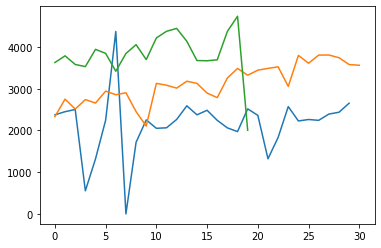

In [16]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

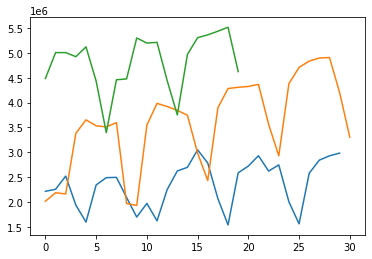

In [17]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [18]:
dataset_twt = df_twt.values
dataset_twt = dataset_twt.astype('float32')

dataset_ine = df_ine.values
dataset_ine = dataset_ine.astype('float32')

In [19]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

# Dividimos los datos en sets de entrenamiento y validacion

In [20]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train_twt = dataset_twt[:n_train_days, :]
test_twt = dataset_twt[n_train_days:, :]

train_ine = dataset_ine[:n_train_days, :]
test_ine = dataset_ine[n_train_days:, :]

print(len(train_twt), len(test_twt))

60 21


In [21]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset1, dataset2, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [22]:
# dividimos en entradas y salidas
look_back = 7
trainX, trainY = create_dataset(train_twt, train_ine, look_back)
testX, testY = create_dataset(test_twt, test_ine, look_back)

print(len(trainX), len(testY))

53 14


In [23]:
print(trainX)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [24]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


In [25]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

In [26]:
print(trainX)

[[[0.16999608 0.50126636]
  [0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]]

 [[0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]]

 [[0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]]

 [[0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]]

 [[0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]
  [0.10891479 0.43309414]]

 [[0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  

In [27]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [28]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,2), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,2), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,2)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [29]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,541
Trainable params: 76,541
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0102 - val_loss: 0.0086
Epoch 124/200
53/53 - 0s - loss: 0.0099 - val_loss: 0.0138
Epoch 125/200
53/53 - 0s - loss: 0.0134 - val_loss: 0.0108
Epoch 126/200
53/53 - 0s - loss: 0.0101 - val_loss: 0.0119
Epoch 127/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0153
Epoch 128/200
53/53 - 0s - loss: 0.0089 - val_loss: 0.0240
Epoch 129/200
53/53 - 0s - loss: 0.0108 - val_loss: 0.0124
Epoch 130/200
53/53 - 0s - loss: 0.0100 - val_loss: 0.0290
Epoch 131/200
53/53 - 0s - loss: 0.0121 - val_loss: 0.0055
Epoch 132/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0277
Epoch 133/200
53/53 - 0s - loss: 0.0090 - val_loss: 0.0186
Epoch 134/200
53/53 - 0s - loss: 0.0116 - val_loss: 0.0186
Epoch 135/200
53/53 - 0s - loss: 0.0122 - val_loss: 0.0183
Epoch 136/200
53/53 - 0s - loss: 0.0111 - val_loss: 0.0084
Epoch 137/200
53/53 - 0s - loss: 0.0084 - val_loss: 0.0136
Epoch 138/200
53/53 - 0s - loss: 0.0086 - val_loss: 0.0124
Epoch 139/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.01

# Visualizamos resultados

In [30]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [31]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [32]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 205669.39 MAE
Resultado del entrenamiento: 82002536188.60 MSE
Resultado del entrenamiento: 286360.85 RMSE
Resultado del entrenamiento: 9.29 CVRMSE
Resultado del entrenamiento: 8.30 MAPE 

Resultado del test: 276690.40 MAE
Resultado del test: 109030375201.93 MSE
Resultado del test: 330197.48 RMSE
Resultado del test: 6.85 CVRMSE
Resultado del test: 6.20 MAPE


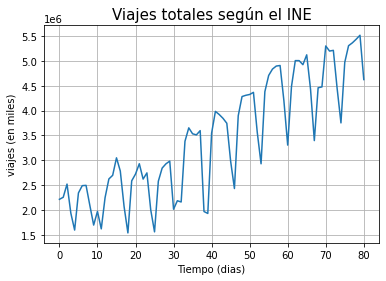

In [33]:
plt.plot(df_ine.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

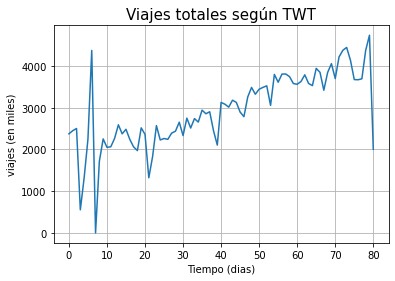

In [34]:
plt.plot(df_twt.values)
plt.grid(True)
plt.title("Viajes totales según TWT", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

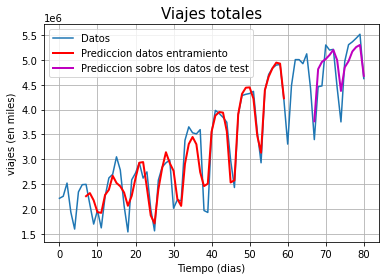

In [35]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset_ine)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset_ine)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_ine), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_ine))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [36]:
results=testPredict
print(len(results))

14


In [37]:
test = testY_scalerInverse[0]

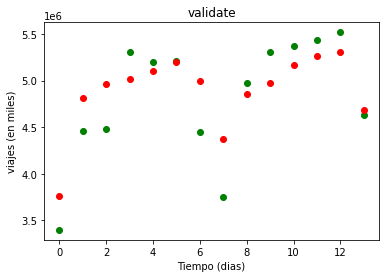

In [38]:
plt.scatter(range(len(test)),test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

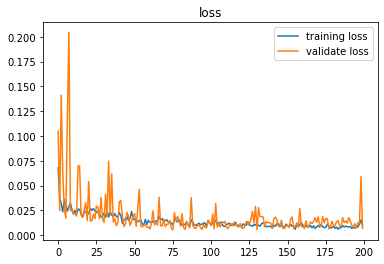

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [40]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

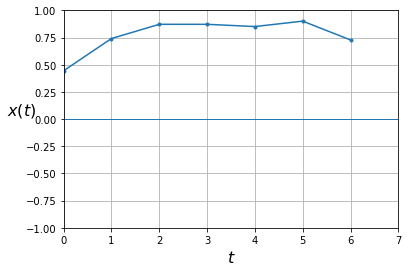

In [41]:
n_steps = 6
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [42]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,3766067.5
2020-06-08,4816095.0
2020-06-09,4962378.5
2020-06-10,5019571.5
2020-06-11,5101446.0
2020-06-12,5203970.5
2020-06-13,4998192.5
2020-06-14,4377189.0
2020-06-15,4853032.0
2020-06-16,4976706.0


In [43]:
datosReales = df_ine['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,3396402,3766067.5
2020-06-08,4461143,4816095.0
2020-06-09,4478072,4962378.5
2020-06-10,5303428,5019571.5
2020-06-11,5200931,5101446.0
2020-06-12,5215302,5203970.5
2020-06-13,4445190,4998192.5
2020-06-14,3753016,4377189.0
2020-06-15,4973188,4853032.0
2020-06-16,5308885,4976706.0


In [44]:
compara.to_excel('Resultados INE - TWT.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [45]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias_twt = df_twt['2020-5-18':'2020-5-24']
Dias_ine = df_ine['2020-5-18':'2020-5-24']

In [46]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset1, dataset2, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back-dias):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [47]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train_twt, train_ine, look_back, 1)
testX1, testY1 = create_dataset2(test_twt, test_ine, look_back, 1)

trainX2, trainY2 = create_dataset2(train_twt, train_ine, look_back, 2)
testX2, testY2 = create_dataset2(test_twt, test_ine, look_back, 2)

trainX3, trainY3 = create_dataset2(train_twt, train_ine, look_back, 3)
testX3, testY3 = create_dataset2(test_twt, test_ine, look_back, 3)

trainX4, trainY4 = create_dataset2(train_twt, train_ine, look_back, 4)
testX4, testY4 = create_dataset2(test_twt, test_ine, look_back, 4)

trainX5, trainY5 = create_dataset2(train_twt, train_ine, look_back, 5)
testX5, testY5 = create_dataset2(test_twt, test_ine, look_back, 5)

trainX6, trainY6 = create_dataset2(train_twt, train_ine, look_back, 6)
testX6, testY6 = create_dataset2(test_twt, test_ine, look_back, 6)

In [48]:
print(trainX1)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [49]:
print(trainY1)

[0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
 0.2914425  0.37988257 0.313093   0.13297123 0.         0.26343662
 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752 0.00537395
 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008 0.16276813
 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993 0.51747626
 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086 0.5796803
 0.5546241  0.3633111  0.22455525 0.59261984 0.689921   0.6962447
 0.7003162  0.71110225 0.50901634 0.34968656 0.7144731  0.7966052
 0.82881963 0.8441757  0.8469062  0.6693162 ]


In [50]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 2))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 2))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 2))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 2))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 2))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 2))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 2))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 2))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 2))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 2))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 2))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 2))

In [51]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,541
Trainable params: 76,541
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0141 - val_loss: 0.0095
Epoch 123/200
52/52 - 0s - loss: 0.0106 - val_loss: 0.0114
Epoch 124/200
52/52 - 0s - loss: 0.0095 - val_loss: 0.0108
Epoch 125/200
52/52 - 0s - loss: 0.0100 - val_loss: 0.0123
Epoch 126/200
52/52 - 0s - loss: 0.0090 - val_loss: 0.0130
Epoch 127/200
52/52 - 0s - loss: 0.0104 - val_loss: 0.0317
Epoch 128/200
52/52 - 0s - loss: 0.0128 - val_loss: 0.0156
Epoch 129/200
52/52 - 0s - loss: 0.0127 - val_loss: 0.0108
Epoch 130/200
52/52 - 0s - loss: 0.0100 - val_loss: 0.0099
Epoch 131/200
52/52 - 0s - loss: 0.0129 - val_loss: 0.0169
Epoch 132/200
52/52 - 0s - loss: 0.0101 - val_loss: 0.0122
Epoch 133/200
52/52 - 0s - loss: 0.0116 - val_loss: 0.0138
Epoch 134/200
52/52 - 0s - loss: 0.0100 - val_loss: 0.0112
Epoch 135/200
52/52 - 0s - loss: 0.0112 - val_loss: 0.0103
Epoch 136/200
52/52 - 0s - loss: 0.0070 - val_loss: 0.0114
Epoch 137/200
52/52 - 0s - loss: 0.0089 - val_loss: 0.0107
Epoch 138/200
52/52 - 0s - loss: 0.0082 - val_loss: 0.0139
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0176 - val_loss: 0.0495
Epoch 44/200
51/51 - 0s - loss: 0.0162 - val_loss: 0.0133
Epoch 45/200
51/51 - 0s - loss: 0.0140 - val_loss: 0.0112
Epoch 46/200
51/51 - 0s - loss: 0.0146 - val_loss: 0.0164
Epoch 47/200
51/51 - 0s - loss: 0.0135 - val_loss: 0.0182
Epoch 48/200
51/51 - 0s - loss: 0.0151 - val_loss: 0.0088
Epoch 49/200
51/51 - 0s - loss: 0.0170 - val_loss: 0.0149
Epoch 50/200
51/51 - 0s - loss: 0.0133 - val_loss: 0.0461
Epoch 51/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0092
Epoch 52/200
51/51 - 0s - loss: 0.0148 - val_loss: 0.0100
Epoch 53/200
51/51 - 0s - loss: 0.0140 - val_loss: 0.0088
Epoch 54/200
51/51 - 0s - loss: 0.0129 - val_loss: 0.0097
Epoch 55/200
51/51 - 0s - loss: 0.0168 - val_loss: 0.0191
Epoch 56/200
51/51 - 0s - loss: 0.0148 - val_loss: 0.0091
Epoch 57/200
51/51 - 0s - loss: 0.0154 - val_loss: 0.0339
Epoch 58/200
51/51 - 0s - loss: 0.0140 - val_loss: 0.0142
Epoch 59/200
51/51 - 0s - loss: 0.0125 - val_loss: 0.0111
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0071 - val_loss: 0.0116
Epoch 184/200
51/51 - 0s - loss: 0.0096 - val_loss: 0.0128
Epoch 185/200
51/51 - 0s - loss: 0.0105 - val_loss: 0.0112
Epoch 186/200
51/51 - 0s - loss: 0.0084 - val_loss: 0.0104
Epoch 187/200
51/51 - 0s - loss: 0.0086 - val_loss: 0.0091
Epoch 188/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0120
Epoch 189/200
51/51 - 0s - loss: 0.0074 - val_loss: 0.0143
Epoch 190/200
51/51 - 0s - loss: 0.0075 - val_loss: 0.0258
Epoch 191/200
51/51 - 0s - loss: 0.0122 - val_loss: 0.0538
Epoch 192/200
51/51 - 0s - loss: 0.0081 - val_loss: 0.0093
Epoch 193/200
51/51 - 0s - loss: 0.0070 - val_loss: 0.0101
Epoch 194/200
51/51 - 0s - loss: 0.0083 - val_loss: 0.0126
Epoch 195/200
51/51 - 0s - loss: 0.0080 - val_loss: 0.0115
Epoch 196/200
51/51 - 0s - loss: 0.0089 - val_loss: 0.0180
Epoch 197/200
51/51 - 0s - loss: 0.0081 - val_loss: 0.0119
Epoch 198/200
51/51 - 0s - loss: 0.0088 - val_loss: 0.0162
Epoch 199/200
51/51 - 0s - loss: 0.0082 - val_loss: 0.01

50/50 - 0s - loss: 0.0121 - val_loss: 0.0158
Epoch 105/200
50/50 - 0s - loss: 0.0125 - val_loss: 0.0164
Epoch 106/200
50/50 - 0s - loss: 0.0109 - val_loss: 0.0115
Epoch 107/200
50/50 - 0s - loss: 0.0106 - val_loss: 0.0127
Epoch 108/200
50/50 - 0s - loss: 0.0107 - val_loss: 0.0174
Epoch 109/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0108
Epoch 110/200
50/50 - 0s - loss: 0.0124 - val_loss: 0.0129
Epoch 111/200
50/50 - 0s - loss: 0.0117 - val_loss: 0.0133
Epoch 112/200
50/50 - 0s - loss: 0.0092 - val_loss: 0.0114
Epoch 113/200
50/50 - 0s - loss: 0.0121 - val_loss: 0.0126
Epoch 114/200
50/50 - 0s - loss: 0.0100 - val_loss: 0.0115
Epoch 115/200
50/50 - 0s - loss: 0.0113 - val_loss: 0.0108
Epoch 116/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0091
Epoch 117/200
50/50 - 0s - loss: 0.0109 - val_loss: 0.0100
Epoch 118/200
50/50 - 0s - loss: 0.0107 - val_loss: 0.0120
Epoch 119/200
50/50 - 0s - loss: 0.0125 - val_loss: 0.0158
Epoch 120/200
50/50 - 0s - loss: 0.0110 - val_loss: 0.0116
Epoch 121/2

49/49 - 0s - loss: 0.0161 - val_loss: 0.0258
Epoch 25/200
49/49 - 0s - loss: 0.0151 - val_loss: 0.0625
Epoch 26/200
49/49 - 0s - loss: 0.0174 - val_loss: 0.1287
Epoch 27/200
49/49 - 0s - loss: 0.0185 - val_loss: 0.0501
Epoch 28/200
49/49 - 0s - loss: 0.0164 - val_loss: 0.0277
Epoch 29/200
49/49 - 0s - loss: 0.0149 - val_loss: 0.0259
Epoch 30/200
49/49 - 0s - loss: 0.0167 - val_loss: 0.0212
Epoch 31/200
49/49 - 0s - loss: 0.0140 - val_loss: 0.0139
Epoch 32/200
49/49 - 0s - loss: 0.0168 - val_loss: 0.0675
Epoch 33/200
49/49 - 0s - loss: 0.0145 - val_loss: 0.0128
Epoch 34/200
49/49 - 0s - loss: 0.0219 - val_loss: 0.0107
Epoch 35/200
49/49 - 0s - loss: 0.0177 - val_loss: 0.0415
Epoch 36/200
49/49 - 0s - loss: 0.0141 - val_loss: 0.0099
Epoch 37/200
49/49 - 0s - loss: 0.0151 - val_loss: 0.0350
Epoch 38/200
49/49 - 0s - loss: 0.0132 - val_loss: 0.0661
Epoch 39/200
49/49 - 0s - loss: 0.0174 - val_loss: 0.0235
Epoch 40/200
49/49 - 0s - loss: 0.0154 - val_loss: 0.0577
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0108 - val_loss: 0.0047
Epoch 166/200
49/49 - 0s - loss: 0.0097 - val_loss: 0.0035
Epoch 167/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0055
Epoch 168/200
49/49 - 0s - loss: 0.0116 - val_loss: 0.0148
Epoch 169/200
49/49 - 0s - loss: 0.0098 - val_loss: 0.0114
Epoch 170/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0207
Epoch 171/200
49/49 - 0s - loss: 0.0098 - val_loss: 0.0052
Epoch 172/200
49/49 - 0s - loss: 0.0097 - val_loss: 0.0043
Epoch 173/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0052
Epoch 174/200
49/49 - 0s - loss: 0.0109 - val_loss: 0.0090
Epoch 175/200
49/49 - 0s - loss: 0.0110 - val_loss: 0.0212
Epoch 176/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.0090
Epoch 177/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0170
Epoch 178/200
49/49 - 0s - loss: 0.0114 - val_loss: 0.0072
Epoch 179/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.0128
Epoch 180/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0112
Epoch 181/200
49/49 - 0s - loss: 0.0099 - val_loss: 0.00

Epoch 86/200
48/48 - 0s - loss: 0.0118 - val_loss: 0.0101
Epoch 87/200
48/48 - 0s - loss: 0.0116 - val_loss: 0.0184
Epoch 88/200
48/48 - 0s - loss: 0.0090 - val_loss: 0.0557
Epoch 89/200
48/48 - 0s - loss: 0.0114 - val_loss: 0.0134
Epoch 90/200
48/48 - 0s - loss: 0.0096 - val_loss: 0.0584
Epoch 91/200
48/48 - 0s - loss: 0.0134 - val_loss: 0.0439
Epoch 92/200
48/48 - 0s - loss: 0.0117 - val_loss: 0.0178
Epoch 93/200
48/48 - 0s - loss: 0.0100 - val_loss: 0.0296
Epoch 94/200
48/48 - 0s - loss: 0.0118 - val_loss: 0.0138
Epoch 95/200
48/48 - 0s - loss: 0.0106 - val_loss: 0.0218
Epoch 96/200
48/48 - 0s - loss: 0.0094 - val_loss: 0.0432
Epoch 97/200
48/48 - 0s - loss: 0.0102 - val_loss: 0.0071
Epoch 98/200
48/48 - 0s - loss: 0.0094 - val_loss: 0.0062
Epoch 99/200
48/48 - 0s - loss: 0.0120 - val_loss: 0.0100
Epoch 100/200
48/48 - 0s - loss: 0.0120 - val_loss: 0.0121
Epoch 101/200
48/48 - 0s - loss: 0.0108 - val_loss: 0.0170
Epoch 102/200
48/48 - 0s - loss: 0.0110 - val_loss: 0.0359
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0380 - val_loss: 0.0320
Epoch 7/200
47/47 - 0s - loss: 0.0355 - val_loss: 0.0398
Epoch 8/200
47/47 - 0s - loss: 0.0334 - val_loss: 0.1266
Epoch 9/200
47/47 - 0s - loss: 0.0385 - val_loss: 0.1740
Epoch 10/200
47/47 - 0s - loss: 0.0654 - val_loss: 0.0272
Epoch 11/200
47/47 - 0s - loss: 0.0412 - val_loss: 0.0348
Epoch 12/200
47/47 - 0s - loss: 0.0361 - val_loss: 0.0339
Epoch 13/200
47/47 - 0s - loss: 0.0445 - val_loss: 0.0245
Epoch 14/200
47/47 - 0s - loss: 0.0406 - val_loss: 0.0263
Epoch 15/200
47/47 - 0s - loss: 0.0395 - val_loss: 0.0240
Epoch 16/200
47/47 - 0s - loss: 0.0336 - val_loss: 0.0476
Epoch 17/200
47/47 - 0s - loss: 0.0314 - val_loss: 0.0253
Epoch 18/200
47/47 - 0s - loss: 0.0362 - val_loss: 0.0331
Epoch 19/200
47/47 - 0s - loss: 0.0397 - val_loss: 0.0350
Epoch 20/200
47/47 - 0s - loss: 0.0421 - val_loss: 0.0244
Epoch 21/200
47/47 - 0s - loss: 0.0343 - val_loss: 0.0238
Epoch 22/200
47/47 - 0s - loss: 0.0356 - val_loss: 0.1113
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0103 - val_loss: 0.0067
Epoch 148/200
47/47 - 0s - loss: 0.0069 - val_loss: 0.0166
Epoch 149/200
47/47 - 0s - loss: 0.0094 - val_loss: 0.0106
Epoch 150/200
47/47 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 151/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.0331
Epoch 152/200
47/47 - 0s - loss: 0.0085 - val_loss: 0.0072
Epoch 153/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0050
Epoch 154/200
47/47 - 0s - loss: 0.0083 - val_loss: 0.0198
Epoch 155/200
47/47 - 0s - loss: 0.0075 - val_loss: 0.0123
Epoch 156/200
47/47 - 0s - loss: 0.0070 - val_loss: 0.0178
Epoch 157/200
47/47 - 0s - loss: 0.0076 - val_loss: 0.0074
Epoch 158/200
47/47 - 0s - loss: 0.0075 - val_loss: 0.0105
Epoch 159/200
47/47 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 160/200
47/47 - 0s - loss: 0.0080 - val_loss: 0.0121
Epoch 161/200
47/47 - 0s - loss: 0.0062 - val_loss: 0.0105
Epoch 162/200
47/47 - 0s - loss: 0.0077 - val_loss: 0.0064
Epoch 163/200
47/47 - 0s - loss: 0.0066 - val_loss: 0.00

# Preparamos los datos para el test

In [52]:
# cargamos el dataframe en la variable dataset
dataset_twt = Dias_twt.values
dataset_ine = Dias_ine.values

# convertimos los enteros en floats
dataset_twt = dataset_twt.astype('float32')
dataset_ine = dataset_ine.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

In [53]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset3(dataset1, dataset2):
  dataX = []
  for x in range(len(dataset2)):
    dataX.append(dataset2[x])  
    dataX.append(dataset1[x])
  dataX = np.array(dataX)
  dataX = np.reshape(dataX, (7, 1, 2))
  return np.array(dataX)

In [54]:
# usamos la funcion definida previamente para crear el dataset
testX = create_dataset3(dataset_twt, dataset_ine)

In [55]:
#remodelamos los datos
testX = np.reshape(testX, (1, 7, 2))

# Realizamos la prediccion 

In [56]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.8153063 ]
 [1.0282434 ]
 [1.0301554 ]
 [1.0376084 ]
 [1.0839455 ]
 [0.5570464 ]
 [0.44572172]]


# Re-Convertimos los resultados

In [57]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[4102877],
       [4409468],
       [4412222],
       [4422952],
       [4489670],
       [3731029],
       [3570741]])

# Visualizamos el pronostico

<AxesSubplot:>

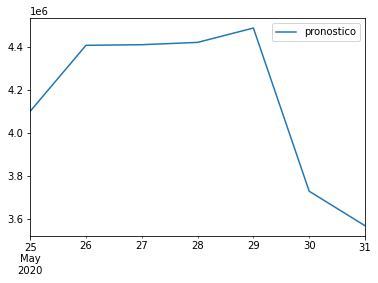

In [58]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [59]:
datosReales = df_ine['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,4102877
2020-05-26,4709433,4409468
2020-05-27,4837770,4412222
2020-05-28,4898946,4422952
2020-05-29,4909824,4489670
2020-05-30,4202334,3731029
2020-05-31,3305717,3570741


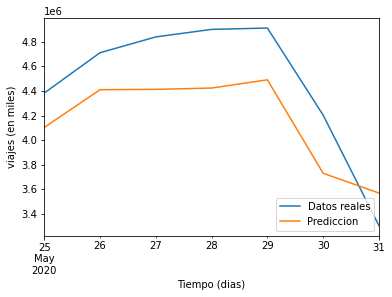

In [60]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [61]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 376763.57 MAE
Resultado del test: 149225016129.57 MSE
Resultado del test: 386296.54 RMSE
Resultado del test: 9.28 CVRMSE
Resultado del test: 9.06 MAPE


In [62]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 279355.00 MAE
Resultado del test dia 1: 78039216025.00 MSE
Resultado del test dia 1: 279355.00 RMSE
Resultado del test dia 1: 6.81 CVRMSE
Resultado del test dia 1: 6.81 MAPE 

Resultado del test dia 2: 299965.00 MAE
Resultado del test dia 2: 89979001225.00 MSE
Resultado del test dia 2: 299965.00 RMSE
Resultado del test dia 2: 6.80 CVRMSE
Resultado del test dia 2: 6.80 MAPE 

Resultado del test dia 3: 425548.00 MAE
Resultado del test dia 3: 181091100304.00 MSE
Resultado del test dia 3: 425548.00 RMSE
Resultado del test dia 3: 9.64 CVRMSE
Resultado del test dia 3: 9.64 MAPE 

Resultado del test dia 4: 475994.00 MAE
Resultado del test dia 4: 226570288036.00 MSE
Resultado del test dia 4: 475994.00 RMSE
Resultado del test dia 4: 10.76 CVRMSE
Resultado del test dia 4: 10.76 MAPE 

Resultado del test dia 5: 420154.00 MAE
Resultado del test dia 5: 176529383716.00 MSE
Resultado del test dia 5: 420154.00 RMSE
Resultado del test dia 5: 9.36 CVRMSE
Resultado del test dia 